## Introduction

This notebook is an implementation of the greedy poisoning attack on regression models as described in Kornaropoulos et. al - *The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures* (paper available on [Arxiv](https://arxiv.org/abs/2008.00297))

**TODO**: 
* Write proper documentation
* Speed-up implementation of Algorithm 1

In [260]:
import csv
import numpy as np
import pandas as pd
from itertools import groupby

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt  
import warnings, datetime
import scipy.stats as ss

## Greedy Poisoning Regression CDF

The following code implements **Algorithm 1 (Greedy Poisoning Regression CDF)** as described in the paper "*The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures*".

In [261]:
# Extracts non-occupied keys for a given sequence
def extract_non_occupied_keys(keyset):
    n = keyset.shape[0]
    
    lower_bound = int(keyset[0]-1)
    upper_bound = int(keyset[n-1]+1)
    
    non_occupied_keys = []
    for i in range(lower_bound, upper_bound + 1):
        if i not in keyset:
            non_occupied_keys.append(i)
        
    return non_occupied_keys

# Groups a list of keys into subsequences of consecutive keys 
def extract_seq(seq):
    return [
        [x for _, x in g]
        for k, g in groupby(
            enumerate(seq), 
            lambda i_x : i_x[0] - i_x[1]
        )
    ]   

# Extract the endpoints of each subsequence
def extract_endpoints(subsequences):
    endpoints = []
    for sequence in subsequences:
        if len(sequence) == 1:
            endpoints.append(sequence[0])
        else:
            endpoints.append(sequence[0])
            endpoints.append(sequence[len(sequence)-1])
            
    return endpoints

# Partition the non-occupied keys, i.e., keys not in K ∪ P, into subsequences such that each subsequence consists of consecutive non-occupied keys;
def partition_non_occupied_keys(K, P):
    keyset = np.append(K, list(P))
    keyset = np.sort(keyset)

    non_occupied_keys = extract_non_occupied_keys(keyset)
    
    subsequences = extract_seq(non_occupied_keys)
    endpoints = extract_endpoints(subsequences)
    return np.array(endpoints)

# Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence
def compute_rank_for_endpoints(endpoints, keyset):
    computed_rank_for_endpoint = []
    
    for endpoint in endpoints:
        keyset_extended = np.append(keyset, endpoint)
        rank = list(ss.rankdata(keyset_extended))
        # extract rank for the last element in the list (endpoint)
        computed_rank_for_endpoint.append(int(rank[len(rank)-1]))
    
    return computed_rank_for_endpoint
    

In [262]:
import operator
from statistics import mean

def obtain_poisoning_keys(p, keyset, rankset):
    # Total number of elements
    n = keyset.shape[0]

    # Number of posoning keys p
    P = p * n
    poisoning_keys = set()

    for j in range(int(P)):
        # Partition the non-occupied keys into subsequences such that each subsequence consists of consecutive non-occupied keys;
        # Extract the endpoints of each subsequence and sort them to construct the new sequence of endpoints S(i), where i <= 2(n + j);
        endpoints = partition_non_occupied_keys(keyset, poisoning_keys)

        # Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence T (i), where i <= 2(n + j) ;
        list_rank = compute_rank_for_endpoints(endpoints, keyset)

        # Compute the effect of choosing S(1) as a poisoning key and inserting it to K ∪ P with the appropriate rank adjustments. 
        # Specifically, evaluate the sequences each of which is the mean M for a different variable, e.g., K, R, KR. Compute MK (1), MK2 (1), MKR(1), and L(1) ;
        S = endpoints
        T = list_rank
        
        delta_S = {}
        M_K = {}
        M_K_square = {}
        M_R = {}
        M_R_square = {}
        M_KR = {}
        L = {}
        
        # Calculate M_K(1), M_R(1) etc.
        current_keyset = np.append(keyset, S[0])
        M_K[0] = np.mean(keyset)

        current_rankset = np.append(rankset, T[0])
        M_R[0] = np.mean(rankset)

        M_K_square[0] = np.mean(keyset**2)

        M_R_square[0] = np.mean(rankset**2)

        M_KR[0] = np.mean(keyset*rankset)

        nominator = (M_KR[0] - (M_K[0] * M_R[0]))**2
        denominator = M_K_square[0] - (M_K[0])**2
        L[0] = - (nominator / denominator) + M_R_square[0] - (M_R[0])**2

        for i in range(1, len(endpoints)-1):
            # Calculate M_K(i), M_R(i) etc.
            delta_S[i] = S[i+1] - S[i] 

            M_K[i] = M_K[i-1] + delta_S[i] / (n) 
            M_K_square[i] = M_K_square[i-1] + (( 2 * S[i] + delta_S[i]) * delta_S[i]) / (n + 1) 

            M_R[i] = (n + 2) / 2
            M_R_square[i] = ((n+2)*(2*n+3)) / 6
            M_KR[i] = M_KR[i-1] + ( T[i-1] * delta_S[i]) / (n + 1)

            nominator = (M_KR[i] - M_K[i]*M_R[i])**2
            denominator = M_K_square[i] - (M_K[i])**2
            L[i] = - (nominator / denominator) + M_R_square[i] - (M_R[i])**2

        # get argmax of items in L
        optimal_key_index = max(L.items(), key=operator.itemgetter(1))[0]
        poisoning_keys.add(S[optimal_key_index])
    
    return poisoning_keys

## Linear regression with non-poisoned keys

In [263]:
df=pd.read_csv('data/random_500.csv', sep=',',header=None)

X = np.array(df[0]).reshape(-1, 1)
y = np.array(df[1])
regressor_legitimate = LinearRegression()
regressor_legitimate.fit(X, y) 

y_pred = regressor_legitimate.predict(X)
mse_legitimate = metrics.mean_squared_error(y, y_pred)

In [264]:
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  

Mean Squared Error: 14.705531571425096


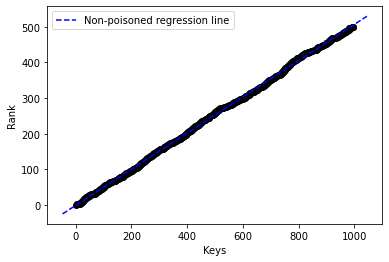

In [265]:
def abline(slope, intercept, color, label):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color, label = label)
    plt.legend()
    plt.xlabel('Keys')
    plt.ylabel('Rank')

# Plot outputs
plt.scatter(X, y,  color='black')
abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
 
plt.show()

## Linear regression with poisoned keys

In [266]:
poisoning_keys = obtain_poisoning_keys(p = 0.2, keyset=X, rankset=y)

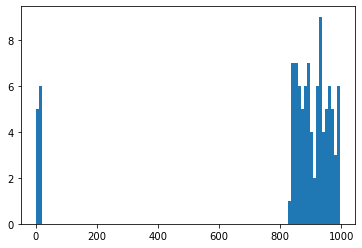

In [267]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def plot_distribution_of_poisoning_keys(poisoning_keys):
    # we observe that poisoning keys are densly populated together
    plt.hist(poisoning_keys, bins = 100, range=[0, df[0][len(df)-1]])
    plt.show()

plot_distribution_of_poisoning_keys(poisoning_keys)

In [268]:
X_poisoned = np.append(X, list(poisoning_keys))
y_poisoned = ss.rankdata(X_poisoned)

In [269]:
X_poisoned = X_poisoned.reshape(-1,1)
regressor_poisoned = LinearRegression()
regressor_poisoned.fit(X_poisoned, y_poisoned)  

y_poisoned_pred = regressor_poisoned.predict(X_poisoned)

In [270]:
print("------------------")
print('Mean Squared Error:', metrics.mean_squared_error(y_poisoned, y_poisoned_pred))  
mse_poisoned = metrics.mean_squared_error(y_poisoned, y_poisoned_pred)

------------------
Mean Squared Error: 300.3537350757655


In [271]:
ratio_loss =  mse_poisoned / mse_legitimate

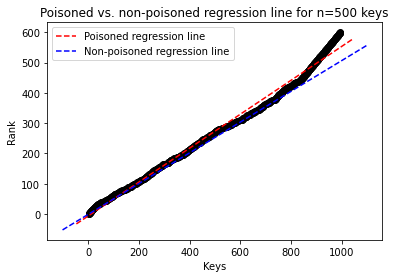

In [272]:
# Plot outputs
plt.scatter(X_poisoned, y_poisoned,  color='black')
abline(regressor_poisoned.coef_, regressor_poisoned.intercept_, color="red", label="Poisoned regression line")
abline(regressor_legitimate.coef_, regressor_legitimate.intercept_, color="blue", label="Non-poisoned regression line")
label= "Poisoned vs. non-poisoned regression line for n="+ str(X.shape[0]) + " keys"
plt.title(label=label)
plt.show()

## Experiments with different key sizes / different poisoning percentages

In [14]:
import random

def generate_uniform_data(size):
    
    data = random.sample(range(2, size * 2), size)
    data.sort()
    return data

In [15]:
dataset_sizes = [500, 1000]

for dataset_size in dataset_sizes:
    
    print("-------------------------")
    print("Dataset size: ", dataset_size)
    X = generate_uniform_data(dataset_size)
    X = np.array(X).reshape(-1, 1)
    
    y = np.linspace(1, dataset_size, num=dataset_size)

    poisoning_percentages = np.linspace(0.01, 0.15, num= 15)

    ratio_losses = []
    
    regressor_legitimate = LinearRegression()
    regressor_legitimate.fit(X, y) 

    y_pred = regressor_legitimate.predict(X)
    mse_legitimate = metrics.mean_squared_error(y, y_pred)

    for percentage in poisoning_percentages:
        poisoning_keys = obtain_poisoning_keys(p = percentage, keyset = X, rankset = y)

        #plot_poisoning_keys(poisoning_keys)

        X_poisoned = np.append(X, list(poisoning_keys))
        y_poisoned = ss.rankdata(X_poisoned)

        X_poisoned = X_poisoned.reshape(-1,1)
        regressor_poisoned = LinearRegression()
        regressor_poisoned.fit(X_poisoned, y_poisoned)  

        y_poisoned_pred = regressor_poisoned.predict(X_poisoned)

        print('Mean Squared Error:', metrics.mean_squared_error(y_poisoned, y_poisoned_pred))  
        mse_poisoned = metrics.mean_squared_error(y_poisoned, y_poisoned_pred)
        ratio_loss =  mse_poisoned / mse_legitimate

        ratio_losses.append(ratio_loss)

    plt.scatter(poisoning_percentages, ratio_losses,  color='black', marker="x")
    plt.xlabel('Poisoning Percentage')
    plt.ylabel('Ratio Loss')
    plt.show()

-------------------------
Dataset size:  500
Mean Squared Error: 20.54275738387361


ValueError: Found input variables with inconsistent numbers of samples: [600, 505]

## Greedy poisoining RMI

The following code implements **Algorithm 2 (Greedy Poisoning RMI)** as described in the paper "*The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures*".

In [310]:
from numpy import unravel_index


# smoothing constant alpha = {2, 3}
alpha = 1

# overall poisoning percentage
phi = 0.1

# number of second-stage models
N = 5

# key set size 
n = df[0].shape[0]

# max. number of poisoning keys per model
t = (alpha*phi*n) / N

# initial size of keysets prior to poisoning
initial_size = n/N

epsilon = 5

num_poisoning_keys = {}

for i in range(N):
    num_poisoning_keys[i] = 0

In [312]:
df=pd.read_csv('data/random_500.csv', sep=',',header=None)

X = np.array(df[0]).reshape(-1, 1)
y = np.array(df[1])

In [313]:
def compute_loss_rmi(X, y):
    
    regressor_poisoned = LinearRegression()
    regressor_poisoned.fit(X, y)

    y_pred = regressor_poisoned.predict(X)
    mse_poisoned = metrics.mean_squared_error(y, y_pred)
    #print('Mean Squared Error:', mse_poisoned) 
    return mse_poisoned


def compute_move_forward(keyset_per_model, poisoning_keys_per_model, changeloss, L_RMI):


    poisoning_keys_per_model_dup = poisoning_keys_per_model.copy()
    keyset_per_model_dup = keyset_per_model.copy()


    for i in range(N-1):
    
        # (A) Add poisoning key to P_i+1
        #
        #
        X_poisoned = np.append(keyset_per_model_dup[i+1], list(poisoning_keys_per_model_dup[i+1]))
        X_poisoned = np.sort(X_poisoned)
        y_poisoned = ss.rankdata(X_poisoned)

        # obtain exactly **one** poisoning key
        p = 1/X_poisoned.shape[0]


        # obtain additional poisoning keys
        poisoning_key =  obtain_poisoning_keys(p = p, keyset = X_poisoned, rankset = y_poisoned)
        # append additional poisoning_key to set
        poisoning_keys_per_model_dup[i+1].update(poisoning_key)


        # (B) Move smallest legitimate key from (i+1)-th to i-th
        #
        #
        keyset_per_model_dup[i] = np.append(keyset_per_model_dup[i], keyset_per_model_dup[i+1][0])

        # delete smallest legitimate key
        keyset_per_model_dup[i+1] = np.delete(keyset_per_model_dup[i+1], 0)


        # (C) Remove poosoning key from P_i
        #
        #
        removed_poisoning_key = poisoning_keys_per_model_dup[i].pop()

        # Compute current loss_RMI
        loss_per_model_changed = {}

        for j in range(N-1):
            X_poisoned = np.append(keyset_per_model_dup[j], list(poisoning_keys_per_model_dup[j]))
            y_poisoned = ss.rankdata(X_poisoned)

            X_poisoned = X_poisoned.reshape(-1,1)

            loss_per_model_changed[i] = compute_loss_rmi(X_poisoned, y_poisoned)


        # Compute L_RMI by averaging the loss of second-sage models
        L_RMI_changed = np.array(list(loss_per_model_changed.values())).mean()
        #print(L_RMI_changed)

        changeloss[i, i+1] = L_RMI_changed - L_RMI

    return changeloss



def compute_move_backward(keyset_per_model, poisoning_keys_per_model, changeloss, L_RMI):

    keyset_per_model_dup = keyset_per_model.copy()
    poisoning_keys_per_model_dup = poisoning_keys_per_model.copy()


    for i in range(N-1):

        # (A) Add poisoning key to P_i
        #
        #
        X_poisoned = np.append(keyset_per_model_dup[i], list(poisoning_keys_per_model_dup[i]))
        X_poisoned = np.sort(X_poisoned)
        y_poisoned = ss.rankdata(X_poisoned)

        # obtain exactly **one** poisoning key
        p = 1/X_poisoned.shape[0]


        # obtain additional poisoning keys
        poisoning_key =  obtain_poisoning_keys(p = p, keyset = X_poisoned, rankset = y_poisoned)
        # append additional poisoning_key to set
        poisoning_keys_per_model_dup[i].update(poisoning_key)


        # (B) Move smallest legitimate key from i-th to (i+1)-th
        #
        #
        keyset_per_model_dup[i+1] = np.append(keyset_per_model_dup[i+1], keyset_per_model_dup[i][-1])

        # delete largest legitimate key
        keyset_per_model_dup[i] = np.delete(keyset_per_model_dup[i], len(keyset_per_model_dup[i]) -1)


        # (C) Remove poosoning key from P_i+1
        #
        #
        removed_poisoning_key = poisoning_keys_per_model_dup[i+1].pop()

        # Compute current loss_RMI
        loss_per_model_changed = {}

        for j in range(N-1):
            X_poisoned = np.append(keyset_per_model_dup[j], list(poisoning_keys_per_model_dup[j]))
            y_poisoned = ss.rankdata(X_poisoned)

            X_poisoned = X_poisoned.reshape(-1,1)

            loss_per_model_changed[i] = compute_loss_rmi(X_poisoned, y_poisoned)


        # Compute L_RMI by averaging the loss of second-sage models
        L_RMI_changed = np.array(list(loss_per_model_changed.values())).mean()

        changeloss[i+1, i] = L_RMI_changed - L_RMI
    
    return changeloss

In [314]:
def greedy_poisoning_regression_rmi(X, y, N):
    
    # Split keyset and rankset into N parts and obtain poisoned keys
    keyset_per_model = np.split(X, N)
    rankset_per_model = np.split(y, N)

    keyset_per_model_orig = keyset_per_model.copy()
    rankset_per_model_orig = rankset_per_model.copy()

    poisoning_keys_per_model = {}
    loss_per_model = {}

    # Initial volume allocation
    # Iterate through all the regression models of the second-stage and for the i-th model, initialize P_i by injecting ϕ*n / N poisoning keys
    # using Algorithm 1
    for i in range(N):
        # convert t into percentage (p = t / 100)
        poisoning_keys_per_model[i] = obtain_poisoning_keys(p = t/100, keyset = keyset_per_model[i], rankset = rankset_per_model[i])

        X_poisoned = np.append(keyset_per_model[i], list(poisoning_keys_per_model[i]))
        # calculate updated rank
        y_poisoned = ss.rankdata(X_poisoned)

        
        X_poisoned = X_poisoned.reshape(-1,1)
        # compute MSE loss for current second-stage model
        loss_per_model[i]  = compute_loss_rmi(X_poisoned, y_poisoned)

    # Compute L_RMI by averaging the loss of second-sage models
    L_RMI = np.array(list(loss_per_model.values())).mean()
    
    
    # Initialize changeloss
    changeloss = np.zeros(shape = (N, N))
    
    
    # Store effect of exchange i -> i+1 in changeloss 
    changeloss = compute_move_forward(keyset_per_model, poisoning_keys_per_model, changeloss, L_RMI)
    
    # Store the effect of exchange i <- i+1 in Changeloss
    changeloss = compute_move_backward(keyset_per_model, poisoning_keys_per_model, changeloss, L_RMI)

    # Greedy iteration that increases the loss of the RMI
    while True:

        # Find indices (i, j) that correspond to largest entry in changeloss
        i, j = unravel_index(changeloss.argmax(), changeloss.shape)

        print(str(i) + ", " + str(j))

        # Make sure that change in L_RMI is larger than epsilon
        if changeloss.argmax() < epsilon:
            break

        changeloss_max = changeloss.argmax()

        # If indices (i, j) violate poisoning threshold t, we obtain the next largest item in changeloss
        while num_poisoning_keys[j] >= t:
            changeloss[i, j] = 0

            i, j = unravel_index(changeloss.argmax(), changeloss.shape)
            print("New:")
            print(str(i) + ", " + str(j))

            # if largest changeloss value is smaller than epsilon, we stop
            if changeloss.argmax() < epsilon:
                break


        # if changeloss below threshold or max number of poisoning keys has been reached for every model, we stop
        if changeloss.argmax() < epsilon or all(i > t for i in list(num_poisoning_keys.values())):
            break

        # peform change i -> j between model i and j 


        # Move legitimate key from j-th to i-th
        #
        #
        if i < j:
            # take smallest element from model j
            keyset_per_model[i] = np.append(keyset_per_model[i], keyset_per_model[j][0])
            # delete smallest legitimate key
            keyset_per_model[j] = np.delete(keyset_per_model[j], 0)
        else: 
            # take largest element from model j
            keyset_per_model[i] = np.append(keyset_per_model[i], keyset_per_model[j][-1])
            # delete largest legitimate key
            keyset_per_model[j] = np.delete(keyset_per_model[j], len(keyset_per_model[j])-1)

        # Add poisoning key to P_j
        #
        #
        added_poisoning_key = poisoning_keys_per_model[j].pop()
        keyset_per_model[j] = np.append(keyset_per_model[j], added_poisoning_key)


        # Remove one poisoning key from P_i
        #
        #
        removed_poisoning_key = poisoning_keys_per_model[i].pop()

        # Obtain fresh poisoning keys

        poisoning_keys_per_model = {}
        for k in range(N):
            keyset_per_model[k] = np.sort(keyset_per_model[k])
            rankset_per_model[k] = ss.rankdata(keyset_per_model[k])
            poisoning_keys_per_model[k] = obtain_poisoning_keys(p = t/100, keyset = keyset_per_model[k], rankset = rankset_per_model[k])


        # Update changeloss values
        changeloss = np.zeros(shape = (N, N))
        changeloss = compute_move_forward(changeloss)
        changeloss = compute_move_backward(changeloss)
        print(changeloss)

        # Update number of poisoning keys for current model
        num_poisoning_keys[j] += 1



3, 2
100
100
100
101
100
[[  0.           3.55219989   0.           0.           0.        ]
 [  3.48272874   0.           3.55219989   0.           0.        ]
 [  0.           3.48272874   0.           4.39997336   0.        ]
 [  0.           0.         313.15958615   0.           3.50412777]
 [  0.           0.           0.           3.49914978   0.        ]]
3, 2
100
100
100
102
100
[[  0.           3.66898635   0.           0.           0.        ]
 [  3.60210817   0.           3.66898635   0.           0.        ]
 [  0.           3.60210817   0.           4.47587114   0.        ]
 [  0.           0.         311.20090229   0.           3.56960386]
 [  0.           0.           0.           3.617356     0.        ]]
3, 2
100
100
100
103
100
[[  0.           3.79077879   0.           0.           0.        ]
 [  3.72636971   0.           3.79077879   0.           0.        ]
 [  0.           3.72636971   0.           4.6148526    0.        ]
 [  0.           0.         309.1334957

100
108
106
110
100
[[  0.          19.42511107   0.           0.           0.        ]
 [ 20.47744842   0.          19.42511107   0.           0.        ]
 [  0.          20.47744842   0.          20.45930162   0.        ]
 [  0.           0.         356.1562421    0.          19.84861301]
 [  0.           0.           0.          19.21059545   0.        ]]
3, 2
New:
1, 0
100
109
106
110
100
[[  0.          19.42511107   0.           0.           0.        ]
 [ 20.47744842   0.          19.42511107   0.           0.        ]
 [  0.          20.47744842   0.          20.45930162   0.        ]
 [  0.           0.         357.21545474   0.          19.84861301]
 [  0.           0.           0.          19.21059545   0.        ]]
3, 2
New:
1, 0
100
110
106
110
100
[[  0.          19.42511107   0.           0.           0.        ]
 [ 20.47744842   0.          19.42511107   0.           0.        ]
 [  0.          20.47744842   0.          20.45930162   0.        ]
 [  0.           0.     

100
110
120
116
100
[[  0.          27.29500053   0.           0.           0.        ]
 [ 27.37042936   0.          27.29500053   0.           0.        ]
 [  0.          27.37042936   0.          28.85636575   0.        ]
 [  0.           0.         405.89979046   0.          27.18654565]
 [  0.           0.           0.          26.74444      0.        ]]
3, 2
New:
2, 3
New:
1, 0
New:
2, 1
New:
0, 1


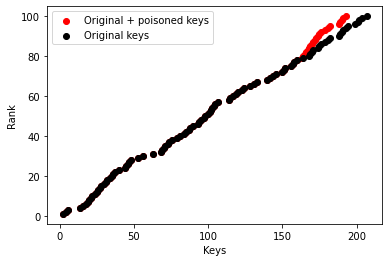

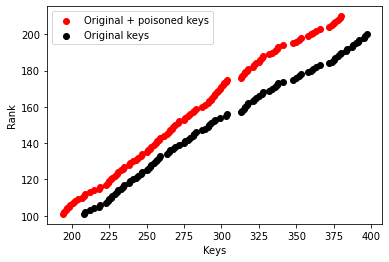

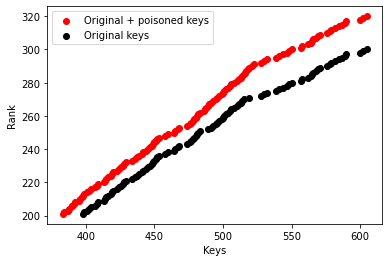

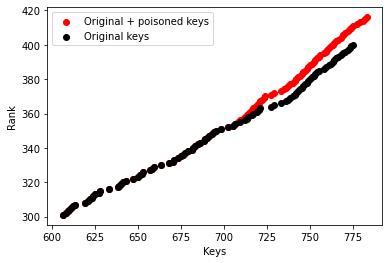

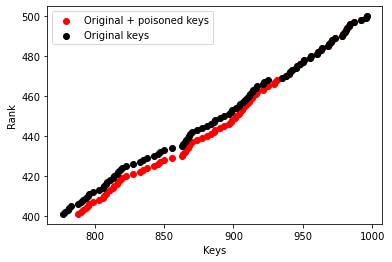

In [332]:
for i in range(N):
    rankset_poisoned = ss.rankdata(keyset_per_model[i])
    
    rank_shift = i*(n/N)
    rankset_poisoned += rank_shift
    
    plt.scatter(keyset_per_model[i], rankset_poisoned,  color='red', label="Original + poisoned keys")
    
    
    plt.scatter(keyset_per_model_orig[i], rankset_per_model_orig[i],  color='black', label="Original keys")
    plt.xlabel("Keys")
    plt.ylabel("Rank")
    plt.legend()
    plt.show()

In [343]:
len(keyset_per_model_orig[4])

100

In [339]:
len(keyset_per_model[4])

100

In [341]:
keyset_per_model[4]

array([788, 790, 792, 794, 795, 796, 799, 803, 806, 807, 808, 809, 811,
       813, 814, 816, 817, 818, 820, 823, 828, 833, 835, 838, 843, 846,
       847, 850, 856, 863, 864, 865, 866, 867, 868, 869, 870, 874, 877,
       881, 884, 886, 887, 890, 893, 897, 898, 899, 901, 902, 904, 905,
       906, 907, 908, 910, 911, 912, 913, 914, 916, 917, 921, 922, 925,
       929, 930, 931, 935, 938, 940, 941, 942, 945, 946, 948, 950, 951,
       955, 956, 960, 961, 963, 964, 968, 969, 970, 971, 973, 978, 979,
       980, 981, 982, 983, 984, 987, 992, 995, 996])

In [345]:
ss.rankdata(keyset_per_model[4])

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])